In [13]:
using BioSequences, DataFrames, CSV, Statistics, StatsPlots, Plots.Measures, GLM

In [14]:
rvariants = CSV.File("rvariants.tsv") |> DataFrame
pvariants = CSV.File("pvariants.tsv") |> DataFrame
onein20 = CSV.File("onein20.csv") |> DataFrame

function row2pvariant(row::Int)
    row = mod(row, 32) - 1
    if row == -1
        row = 0
    end
    "p" * string(row)
end

function custom_cmp(x::AbstractString)
    number_idx = findfirst(isdigit, x)
    str, num = SubString(x, 1, number_idx-1), SubString(x, number_idx, length(x))
    return parse(Int, num), str
 end

names = String[]
for (i, row) in enumerate(eachrow(onein20))
    push!(names, row2pvariant(i))
end
onein20.name = names
dropmissing!(onein20)
select!(onein20, Not(:idx))

Row,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20,r21,r22,r23,r24,r25,r26,r27,r28,r29,r30,r31,r32,r33,r34,r35,r36,r37,r38,r39,r40,r41,r42,r43,r44,r45,name
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String
1,0.118063,0.176024,0.114558,0.0954791,0.0582688,0.069497,0.03698,0.0562783,0.00747029,0.0573139,0.0507736,0.0232313,0.0690145,0.0894754,0.0507519,0.0763012,0.127046,0.0106938,0.102837,0.148886,0.0624836,0.161728,0.0540718,0.102952,0.0189723,0.134211,0.0496539,0.113941,0.0996849,0.0140665,0.12398,0.0287019,0.110333,0.108359,0.063682,0.105155,0.11846,0.0775862,0.120815,0.0961485,0.148789,0.106646,0.165267,0.0446889,0.0945402,0.0250292,p1
2,0.173702,0.160203,0.198582,0.115448,0.0770503,0.11915,0.0374574,0.0856734,0.0194938,0.0985836,0.0947533,0.0316379,0.147395,0.150254,0.0688349,0.123197,0.197348,0.0268937,0.159585,0.243613,0.113607,0.244561,0.0830409,0.198226,0.0465496,0.206377,0.0944206,0.189229,0.185245,0.0419857,0.180989,0.05872,0.189908,0.201231,0.0973854,0.196682,0.188012,0.112203,0.217258,0.126465,0.208506,0.192853,0.226379,0.0847625,0.146047,0.0693413,p2
3,0.0751991,0.0725222,0.0620422,0.0925147,0.0391061,0.0436439,0.0240226,0.0283496,0.00646552,0.0379888,0.0305244,0.0100536,0.0534817,0.0634167,0.0229797,0.04375,0.0743538,0.00552307,0.0583528,0.118629,0.0346603,0.105263,0.02831,0.0694172,0.0134328,0.0891381,0.0309767,0.0688048,0.060312,0.00976205,0.0657809,0.0161476,0.0663793,0.0717345,0.0374053,0.0725832,0.0799419,0.044843,0.0779754,0.0493197,0.0841794,0.060192,0.113492,0.0406571,0.0555755,0.0184414,p3
4,0.0869435,0.0779647,0.0769231,0.0377979,0.179015,0.0769517,0.0489438,0.0287081,0.0150628,0.0365989,0.0328002,0.021913,0.0588889,0.0771552,0.0321962,0.0572864,0.0737783,0.00618893,0.0685794,0.105932,0.0390983,0.0957447,0.0334115,0.0652318,0.0147275,0.0879187,0.0333605,0.0801321,0.0653519,0.00526489,0.0859432,0.0204662,0.06616,0.0835622,0.0349057,0.0630146,0.0855237,0.0438871,0.0884477,0.0411202,0.0908688,0.0765349,0.121707,0.0304199,0.0648688,0.0133998,p4
5,0.146542,0.0939055,0.120498,0.0677592,0.0828308,0.209289,0.0554455,0.0664207,0.0207442,0.0711417,0.0781807,0.0247488,0.108861,0.112554,0.054232,0.0904627,0.142153,0.0155818,0.117711,0.211216,0.0964247,0.204117,0.0712281,0.158353,0.036933,0.147506,0.0800439,0.156178,0.129398,0.0271586,0.148387,0.041466,0.133072,0.14525,0.0695587,0.144175,0.134073,0.102345,0.186215,0.0989555,0.156764,0.15,0.197077,0.0645495,0.123664,0.0467245,p5
6,0.0506508,0.040349,0.0538097,0.0394391,0.0539402,0.0372692,0.0962594,0.0236332,0.00826105,0.029724,0.0258732,0.0128205,0.0410367,0.0404265,0.0197828,0.0325257,0.0528804,0.00868167,0.0355384,0.0673872,0.0245003,0.0611945,0.0225352,0.0322066,0.0138122,0.0471154,0.0233627,0.0573959,0.046875,0.00250627,0.0449353,0.0149502,0.0396367,0.0499316,0.0153846,0.0528771,0.0652406,0.0206813,0.0618661,0.0261105,0.0681034,0.0599206,0.0796214,0.0159902,0.0387374,0.00833333,p6
7,0.10335,0.0705216,0.111898,0.0635436,0.0659889,0.093255,0.0417622,0.173675,0.0314781,0.148487,0.051368,0.0381066,0.066554,0.109487,0.0553462,0.0822326,0.0951249,0.0145512,0.0788083,0.11279,0.0636109,0.112713,0.0424278,0.113832,0.0345559,0.0957256,0.0505637,0.0911802,0.0806976,0.0157092,0.1012,0.0292966,0.123214,0.0938511,0.0399439,0.136095,0.0958904,0.0598463,0.194692,0.0517842,0.152293,0.140585,0.148369,0.0287136,0.123244,0.0174391,p7
8,0.0422535,0.0283308,0.0330515,0.0310371,0.0153349,0.0248489,0.00802855,0.0227416,0.0211961,0.0438719,0.0261473,0.00970874,0.034507,0.0323508,0.0160936,0.0381587,0.0336085,0.00481638,0.0287868,0.052417,0.021978,0.0553797,0.0146062,0.0420216,0.0088968,0.0372066,0.0166782,0.0364583,0.0402145,0.00466744,0.04

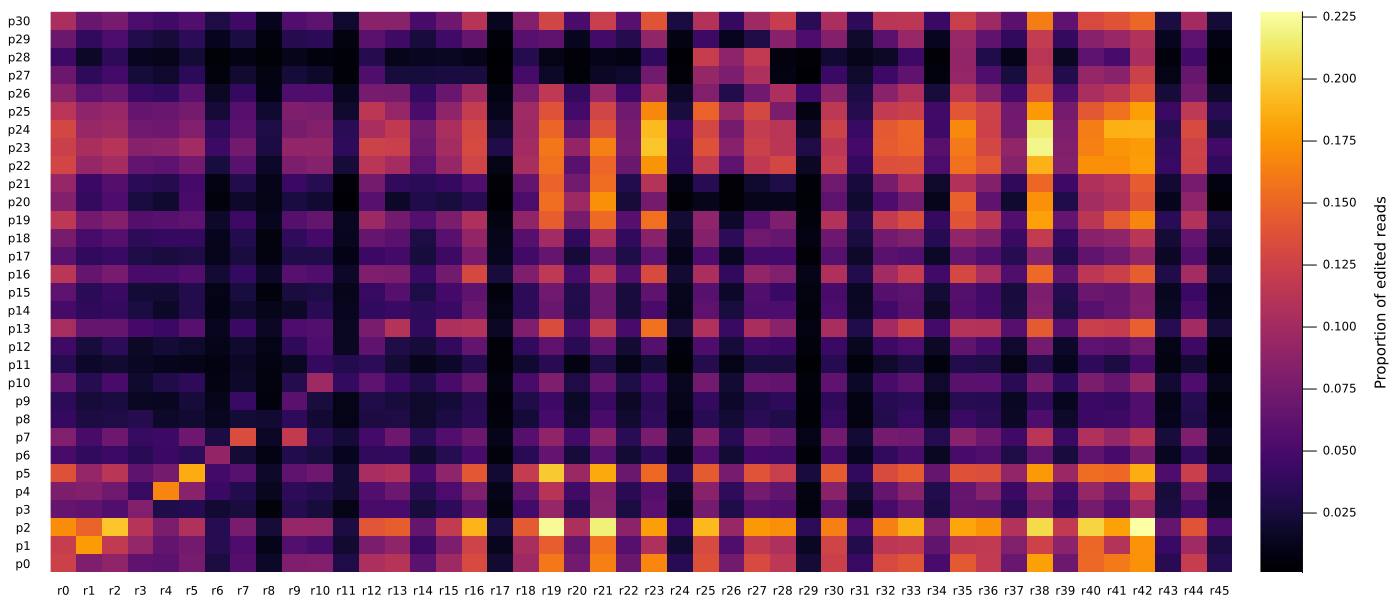

In [ ]:
#Fig. 4A
onein20_means = sort!(combine(groupby(onein20, :name), Not(:name) .=> mean), :name; by = custom_cmp)
plot(Matrix(onein20_means[:,2:47]), st = :heatmap, xticks = (1:46, rvariants.name), yticks = (1:31, pvariants.name[1:31]), size=(1400, 600),
     foreground_color_border = :white, tick_direction = :none, colorbar_title="Proportion of edited reads")

In [16]:
df = stack(onein20, Not(:name))
rename!(df, :name => :protein, :variable => :rna, :value => :editing)
df.batch = fill("a", nrow(df))
df[1:1440, :batch] .= "a"
df[1441:2882, :batch] .= "b"
df[2883:4324, :batch] .= "c"

model = glm(@formula(editing ~ batch + protein + rna + protein&rna), df, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

editing ~ 1 + batch + protein + rna + protein & rna

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                                Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)              -1.95431        1.51663   -1.29    0.1975   -4.92686    1.01824
batch: b                  0.0126896      0.967856   0.01    0.9895   -1.88427    1.90965
batch: c                 -0.0285571      1.25924   -0.02    0.9819   -2.49662    2.43951
protein: p1              -0.0274445      2.33051   -0.01    0.9906   -4.59516    4.54027
protein: p10             -0.724103       2.80067   -0.26    0.7960   -6.213

In [17]:
coefs = DataFrame(coeftable(model))
rename!(coefs,Symbol("Coef.") => :coef)

function name2protein(name::String)
    ~occursin("protein", name) && return missing
    split(name," ")[2]
end

function name2rna(name::String)
    ~occursin("rna", name) && return missing
    last(split(name," "))
end

coefs.protein = name2protein.(coefs.Name)
coefs.rna = name2rna.(coefs.Name)

rna_coefs = coefs[.~ismissing.(coefs.rna) .& ismissing.(coefs.protein), :]
protein_coefs = coefs[.~ismissing.(coefs.protein) .& ismissing.(coefs.rna), :]

interaction_coefs = dropmissing(coefs)
sort!(select!(interaction_coefs, [:protein, :rna, :coef]),[:protein, :rna], by = custom_cmp)

coef_limit = maximum(abs, vcat(rna_coefs.coef, protein_coefs.coef, interaction_coefs.coef))

2.8283947125908075

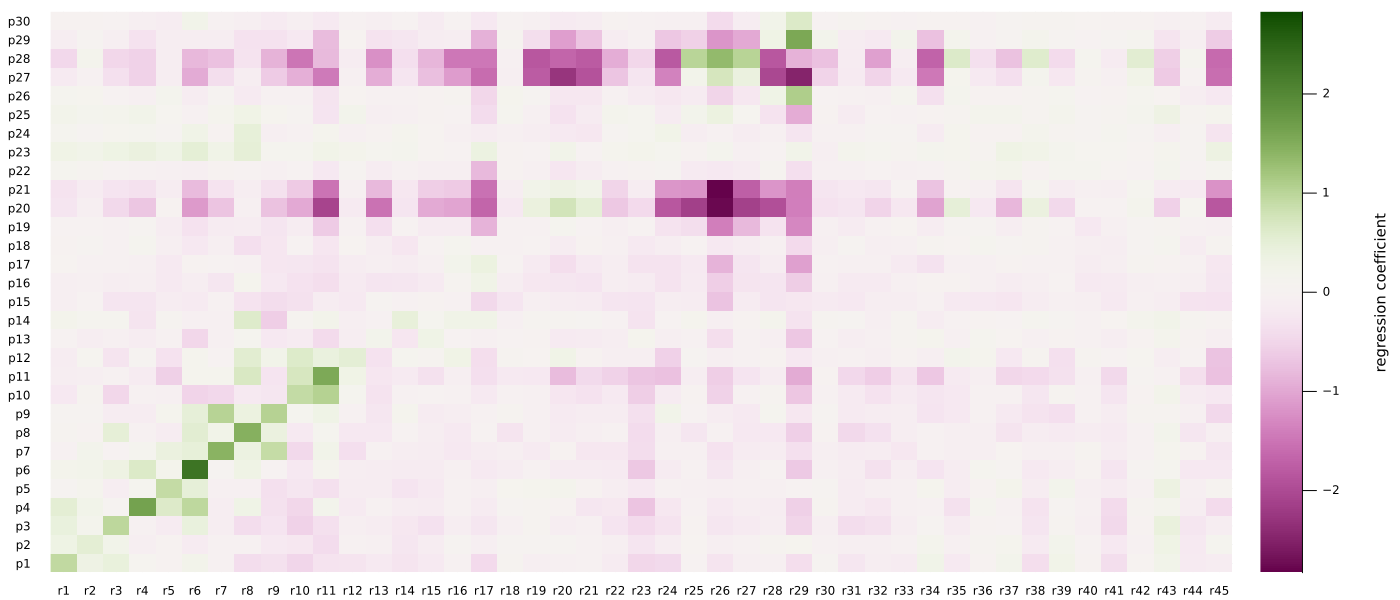

In [ ]:
#Fig. 4B
data = Matrix(unstack(interaction_coefs, :protein, :rna, :coef)[:, 2:46])
plot(data, st = :heatmap, colormap = :bam, clims = (-1, 1) .* coef_limit, xticks = (1:45, rvariants.name[2:end]), yticks = (1:30, pvariants.name[2:end]), size=(1400, 600),
    foreground_color_border = :white, tick_direction = :none, colorbar_title="regression coefficient")

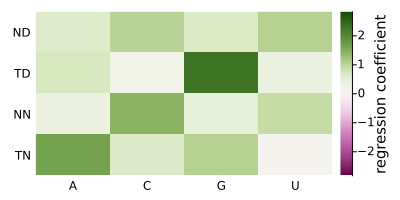

In [ ]:
#Fig. 4C
pvariantmap = Dict("TN" => 1, "NN" => 2, "TD" => 3, "ND" =>4)
rvariantmap = Dict("A" => 1, "C" => 2, "G" => 3, "T" => 4, "U" => 4)

pc = [Float64[] for i in 1:4, j in 1:4]

for m in 1:10, p in 1:3, r in 1:3
    coeff = data[3*(m-1) + p, 3*(m-1) + r]
    combo = pvariants.pvariant[3*(m-1) + p + 1]
    base = rvariants.rvariant[3*(m-1) + r + 1]
    push!(pc[pvariantmap[combo], rvariantmap[base]], coeff)
end

plot(mean.(pc), st = :heatmap, colormap = :bam, clims = (-1, 1) .* maximum(mean.(pc)), xticks = (1:4, ["A", "C", "G", "U"]), yticks = (1:4, ["TN", "NN", "TD", "ND"]), size=(400, 200),
    foreground_color_border = :white, tick_direction = :none, colorbar_title="regression coefficient")

plot(maximum.(pc), st = :heatmap, colormap = :bam, clims = (-1, 1) .* coef_limit, xticks = (1:4, ["A", "C", "G", "U"]), yticks = (1:4, ["TN", "NN", "TD", "ND"]), size=(400, 200),
    foreground_color_border = :white, tick_direction = :none, colorbar_title="regression coefficient")


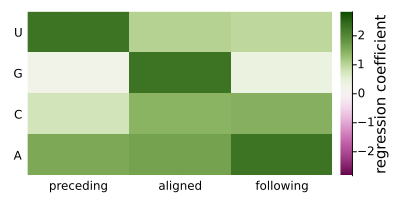

In [ ]:
#Fig. 4D
rpoA = "NUUACACGUGCA"

preceding = [Float64[] for i in 1:4]
target = [Float64[] for i in 1:4]
following = [Float64[] for i in 1:4]

function signedmax(v)
    smax = 0.0
    for n in v
        if abs(n) > smax
            smax = n
        end
    end
    smax
end

for v in 1:27
    coeff = data[v, v]
    m = ceil(Int, v/3) + 1
    pbase = string(rpoA[m-1])
    tbase = rvariants.rvariant[v + 1]
    fbase = string(rpoA[m+1])
    if haskey(rvariantmap, pbase)
        push!(preceding[rvariantmap[pbase]], coeff)
    end
    push!(target[rvariantmap[tbase]], coeff)
    push!(following[rvariantmap[fbase]], coeff)
end

mat = hcat(signedmax.(preceding), signedmax.(target), signedmax.(following))

plot(mat, st = :heatmap, colormap = :bam, clims = (-1, 1) .* coef_limit, xticks = (1:3, ["preceding", "aligned", "following"]), yticks = (1:4, ["A", "C", "G", "U"]), size=(400, 200),
   foreground_color_border = :white, tick_direction = :none, colorbar_title="regression coefficient")


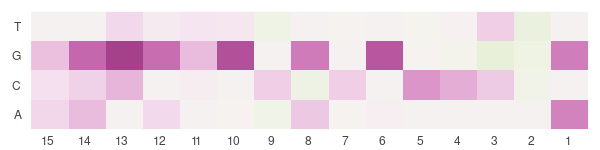

In [21]:
#Fig. 5A
rcoefs = leftjoin(select(rna_coefs, [:rna, :coef]), rvariants; on = :rna => :name)
select!(rcoefs, [:position, :rvariant, :coef])
table = unstack(rcoefs, :rvariant, :position, :coef)
table = coalesce.(table, 0.0)
plot(Matrix(table[:,2:16]), st = :heatmap, colormap = :bam, clims = (-1, 1) .* coef_limit, xticks = (1:15, DataFrames.names(table)[2:end]), yticks = (1:4, table.rvariant),
    fontfamily = "Helvetica", size = (600, 150), cbar = false, foreground_color_border = :white, tick_direction = :none)

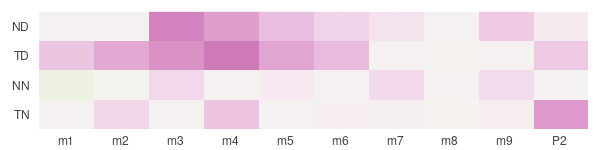

In [22]:
#Fig 6A
pcoefs = leftjoin(select(protein_coefs, [:protein, :coef]), pvariants; on = :protein => :name)
select!(pcoefs, [:protein, :motif, :pvariant, :coef])
table = unstack(pcoefs, :pvariant, :motif, :coef)
table = coalesce.(table, 0.0)
plot(Matrix(table[:,2:11]), st = :heatmap, colormap = :bam, clims = (-1, 1) .* coef_limit, xticks = (1:10, DataFrames.names(table)[2:end]), yticks = (1:4, table.pvariant),
    fontfamily = "Helvetica", size = (600, 150), cbar = false, foreground_color_border = :white, tick_direction = :none)